# Multi-Architecture SQLite Performance Analysis

This notebook analyzes combined timing results from multiple architectures (AMD64, ARM64, RISC-V), comparing native execution vs WebAssembly across different container runtimes and WASM engines.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data Loading and Preparation

In [3]:
# Load the combined CSV data
import glob

# Look for combined results file
combined_files = glob.glob('combined_timing_results_*.csv')
if combined_files:
    # Use the most recent combined file
    combined_files.sort(reverse=True)
    csv_file = combined_files[0]
    print(f"📁 Using combined results file: {csv_file}")
else:
    # Fallback to regular timing_results.csv
    csv_file = 'timing_results.csv'
    print(f"📁 Using single architecture file: {csv_file}")

try:
    df = pd.read_csv(csv_file, quoting=1)
    print(f"✅ Loaded {len(df)} measurements")
    print(f"✅ Columns: {list(df.columns)}")
except FileNotFoundError:
    print(f"❌ {csv_file} not found.")
    print("Run either:")
    print("  1. ./measure_ctr.sh 10  (for single architecture)")
    print("  2. python3 combine_results.py  (to combine multi-arch results)")
    df = None
except Exception as e:
    print(f"❌ Error loading data: {e}")
    df = None

if df is not None:
    # Clean and prepare data
    df['Image Type'] = df['Image'].apply(lambda x: 'WebAssembly' if 'wasm' in x else 'Native')
    
    # Convert timestamps to datetime
    df['Start Time'] = pd.to_datetime(df['Start Timestamp'], unit='s')
    
    # Handle N/A values in timing columns
    timing_columns = ['Container Start to Main Time (s)', 'Main to Elapsed Time (s)']
    for col in timing_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Check if this is a multi-architecture dataset
    has_architecture = 'Architecture' in df.columns
    
    print("\n📊 Data Summary:")
    if has_architecture:
        print(df.groupby(['Architecture', 'Runtime', 'Image Type']).size().to_string())
        print(f"\n🏗️ Architectures detected: {', '.join(df['Architecture'].unique())}")
    else:
        print(df.groupby(['Runtime', 'Image Type']).size().to_string())
        print("\n🏗️ Single architecture dataset")

📁 Using combined results file: combined_timing_results_20250807_062122.csv
✅ Loaded 160 measurements
✅ Columns: ['Runtime', 'Architecture', 'Image', 'Platform', 'Iteration', 'Start Timestamp', 'Pull Complete Timestamp', 'Execution Complete Timestamp', 'Pull Time (s)', 'Container Start to Main Time (s)', 'Main to Elapsed Time (s)', 'Total Execution Time (s)', 'Host Size (MB)', 'WASM_Runtime']

📊 Data Summary:
Architecture  Runtime     Image Type 
AMD64         containerd  Native         10
                          WebAssembly    10
              docker      Native         10
                          WebAssembly    10
ARM64         containerd  Native         10
                          WebAssembly    10
              docker      Native         10
                          WebAssembly    10
RISCV64       containerd  Native         10
                          WebAssembly    30
              docker      Native         10
                          WebAssembly    30

🏗️ Architectures dete

In [4]:
# Display basic statistics
if df is not None:
    print("\n🔍 Data Overview:")
    display(df.head())
    
    print("\n📈 Basic Statistics:")
    numeric_cols = ['Pull Time (s)', 'Container Start to Main Time (s)', 
                   'Main to Elapsed Time (s)', 'Total Execution Time (s)', 'Host Size (MB)']
    display(df[numeric_cols].describe())


🔍 Data Overview:


,Runtime,Architecture,Image,Platform,Iteration,Start Timestamp,Pull Complete Timestamp,Execution Complete Timestamp,Pull Time (s),Container Start to Main Time (s),Main to Elapsed Time (s),Total Execution Time (s),Host Size (MB),WASM_Runtime,Image Type,Start Time
0,docker,AMD64,docker.io/matsbror/massive-sqlite-native:1.1,linux/amd64,1,1754381924,1754381926,1754381927,2.039,0.719,0.199,0.567,3.41,NaN,Native,2025-08-05 08:18:44
1,docker,AMD64,docker.io/matsbror/massive-sqlite-native:1.1,linux/amd64,2,1754381927,1754381929,1754381930,2.008,0.948,0.198,0.593,3.41,NaN,Native,2025-08-05 08:18:47
2,docker,AMD64,docker.io/matsbror/massive-sqlite-native:1.1,linux/amd64,3,1754381930,1754381932,1754381933,1.999,1.175,0.199,0.604,3.41,NaN,Native,2025-08-05 08:18:50
3,docker,AMD64,docker.io/matsbror/massive-sqlite-native:1.1,linux/amd64,4,1754381934,1754381936,1754381936,2.072,0.456,0.197,0.588,3.41,NaN,Native,2025-08-05 08:18:54
4,docker,AMD64,docker.io/matsbror/massive-sqlite-native:1.1,linux/amd64,5,1754381937,1754381939,1754381940,2.092,0.776,0.198,0.601,3.41,NaN,Native,2025-08-05 08:18:57



📈 Basic Statistics:


,Pull Time (s),Container Start to Main Time (s),Main to Elapsed Time (s),Total Execution Time (s),Host Size (MB)
count,160.000000,160.000000,160.000000,160.000000,160.000000
mean,2.210575,9.250781,13.525450,24.053094,1.078750
std,0.581050,13.978134,31.938735,33.652563,1.189423
min,1.032000,0.174000,0.195000,0.353000,0.000000
25%,1.879000,0.957500,0.328750,1.217750,0.000000
50%,2.128000,1.535000,0.829000,2.098000,0.820000
75%,2.550500,12.213000,4.054250,41.797500,1.640000
max,7.099000,45.628000,98.558000,106.422000,3.410000


## Cross-Architecture Performance Comparison

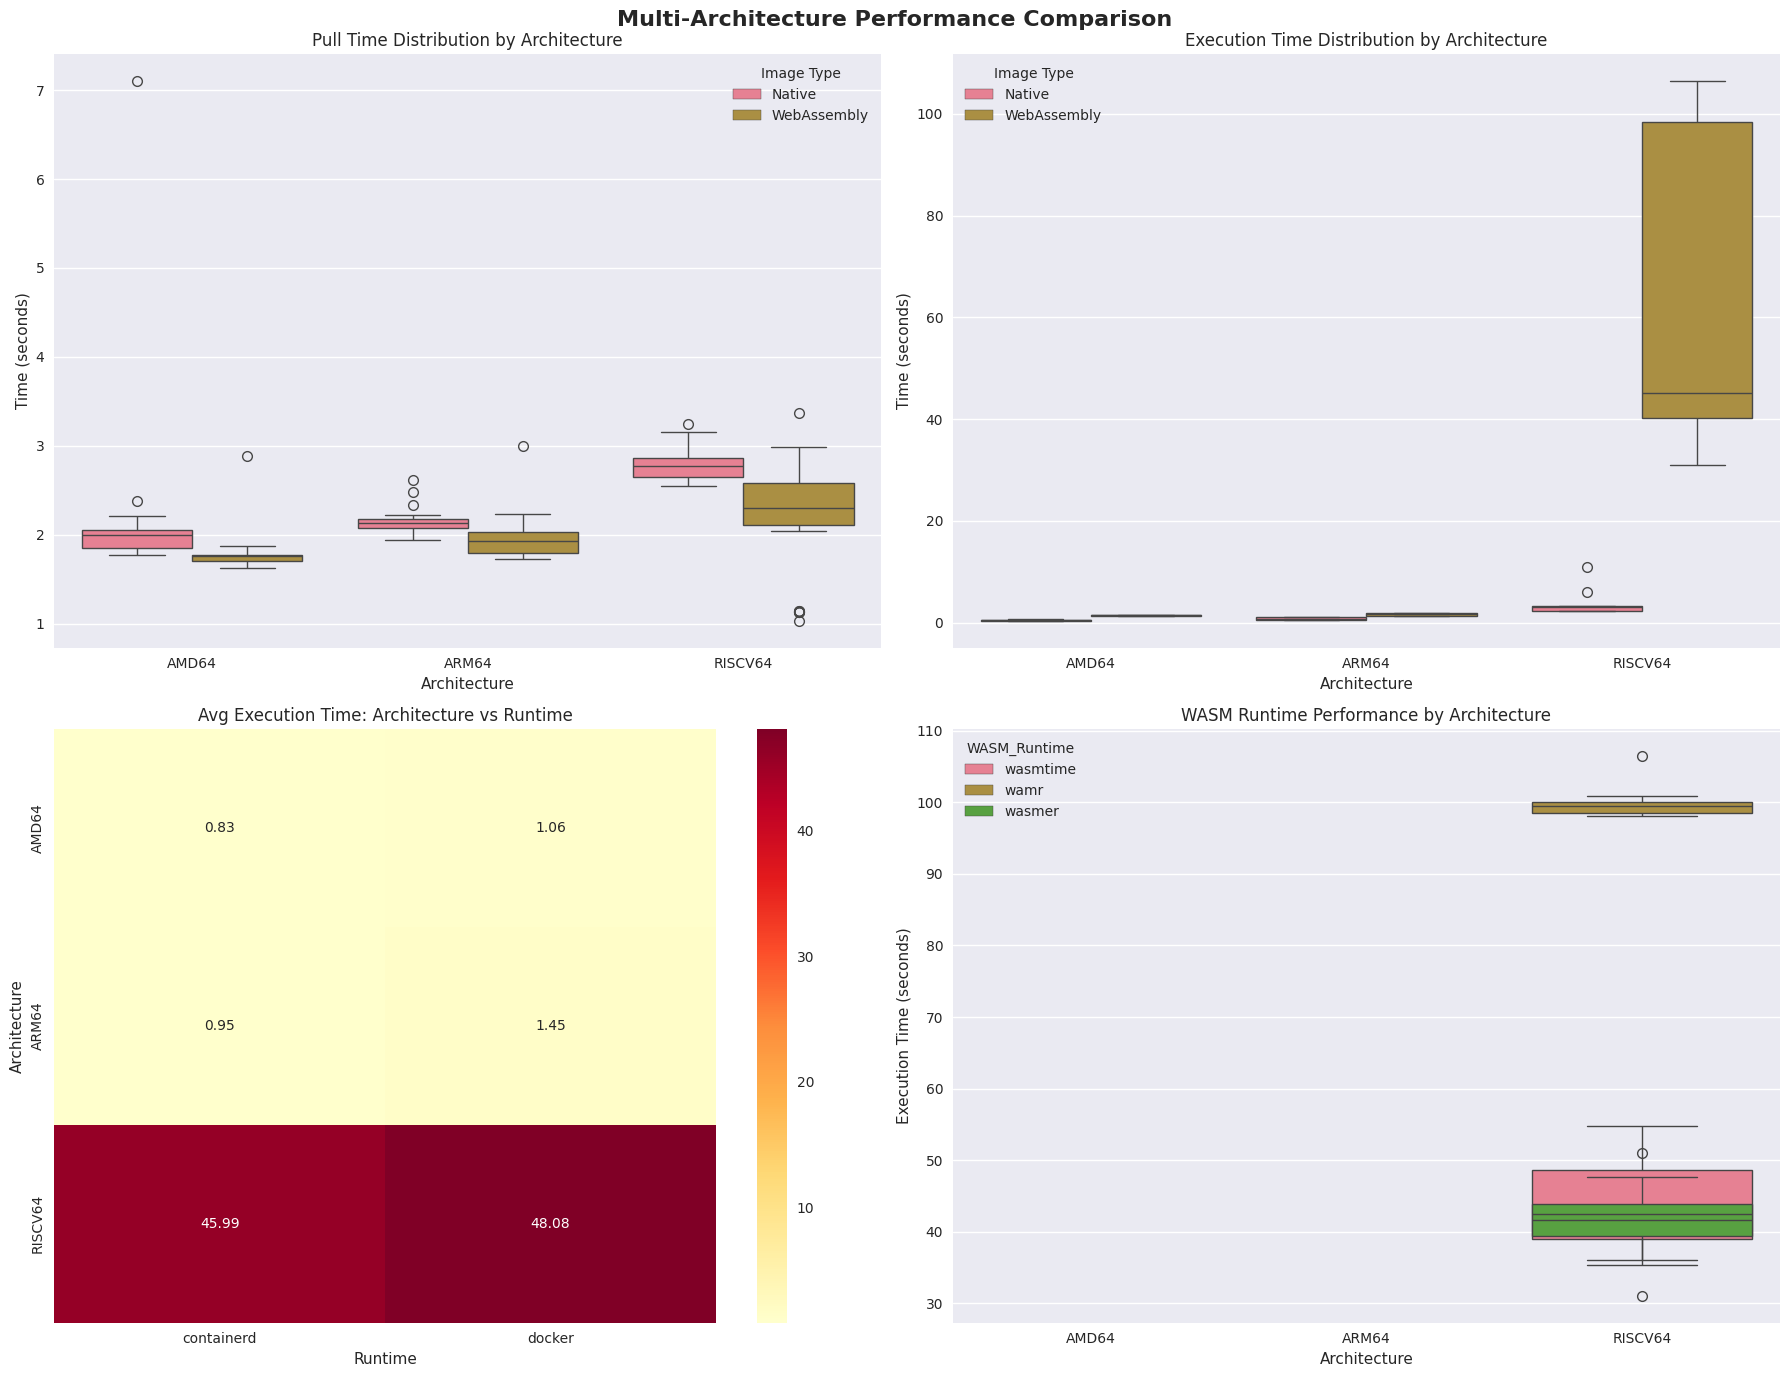

In [5]:
if df is not None and has_architecture:
    # Cross-architecture comparison
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Multi-Architecture Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Pull Time by Architecture
    ax1 = axes[0,0]
    sns.boxplot(data=df, x='Architecture', y='Pull Time (s)', hue='Image Type', ax=ax1)
    ax1.set_title('Pull Time Distribution by Architecture')
    ax1.set_ylabel('Time (seconds)')
    
    # 2. Execution Time by Architecture
    ax2 = axes[0,1]
    sns.boxplot(data=df, x='Architecture', y='Total Execution Time (s)', hue='Image Type', ax=ax2)
    ax2.set_title('Execution Time Distribution by Architecture')
    ax2.set_ylabel('Time (seconds)')
    
    # 3. Architecture vs Runtime Heatmap (Execution Time)
    ax3 = axes[1,0]
    exec_pivot = df.pivot_table(values='Total Execution Time (s)', 
                               index='Architecture', 
                               columns='Runtime', 
                               aggfunc='mean')
    sns.heatmap(exec_pivot, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax3)
    ax3.set_title('Avg Execution Time: Architecture vs Runtime')
    
    # 4. WASM Runtime Performance by Architecture
    ax4 = axes[1,1]
    wasm_data = df[df['Image Type'] == 'WebAssembly']
    if not wasm_data.empty and 'WASM_Runtime' in wasm_data.columns:
        sns.boxplot(data=wasm_data, x='Architecture', y='Total Execution Time (s)', 
                   hue='WASM_Runtime', ax=ax4)
        ax4.set_title('WASM Runtime Performance by Architecture')
        ax4.set_ylabel('Execution Time (seconds)')
    else:
        ax4.text(0.5, 0.5, 'No WASM runtime data available', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('WASM Runtime Performance - No Data')
    
    plt.tight_layout()
    plt.show()
elif df is not None:
    print("⚠️ Single architecture dataset detected. Use the original analyze_timing_results.ipynb for single-arch analysis.")
else:
    print("❌ No data available for analysis")

## Architecture Performance Rankings

In [6]:
if df is not None and has_architecture:
    # Calculate performance rankings by architecture
    print("\n🏆 ARCHITECTURE PERFORMANCE RANKINGS")
    print("=" * 50)
    
    # Overall performance ranking (lower is better)
    arch_perf = df.groupby('Architecture').agg({
        'Pull Time (s)': 'mean',
        'Total Execution Time (s)': 'mean',
        'Container Start to Main Time (s)': 'mean',
        'Host Size (MB)': 'mean'
    }).round(3)
    
    print("\n📊 Average Performance by Architecture:")
    display(arch_perf.sort_values('Total Execution Time (s)'))
    
    # Native vs WASM comparison by architecture
    print("\n🔍 Native vs WASM by Architecture:")
    comparison = df.groupby(['Architecture', 'Image Type'])['Total Execution Time (s)'].mean().unstack()
    comparison['WASM Overhead %'] = ((comparison['WebAssembly'] / comparison['Native']) - 1) * 100
    display(comparison.round(3))
    
    # Best performing combinations
    print("\n🥇 Best Performing Combinations:")
    best_combos = df.groupby(['Architecture', 'Runtime', 'Image Type'])['Total Execution Time (s)'].mean().sort_values().head(10)
    for (arch, runtime, img_type), time_val in best_combos.items():
        print(f"  {arch} + {runtime} + {img_type}: {time_val:.3f}s")
        
elif df is not None:
    print("⚠️ Architecture comparison not available for single-architecture dataset")


🏆 ARCHITECTURE PERFORMANCE RANKINGS

📊 Average Performance by Architecture:


,Pull Time (s),Total Execution Time (s),Container Start to Main Time (s),Host Size (MB)
Architecture,,,,
AMD64,2.005,0.943,1.093,1.262
ARM64,2.059,1.198,1.095,1.165
RISCV64,2.389,47.036,17.407,0.944



🔍 Native vs WASM by Architecture:


Image Type,Native,WebAssembly,WASM Overhead %
Architecture,,,
AMD64,0.491,1.394,183.925
ARM64,0.812,1.584,95.176
RISCV64,3.321,61.607,1755.087



🥇 Best Performing Combinations:
  AMD64 + containerd + Native: 0.387s
  ARM64 + containerd + Native: 0.577s
  AMD64 + docker + Native: 0.596s
  ARM64 + docker + Native: 1.047s
  AMD64 + containerd + WebAssembly: 1.264s
  ARM64 + containerd + WebAssembly: 1.314s
  AMD64 + docker + WebAssembly: 1.525s
  ARM64 + docker + WebAssembly: 1.854s
  RISCV64 + containerd + Native: 3.199s
  RISCV64 + docker + Native: 3.443s


## WASM Runtime Analysis Across Architectures

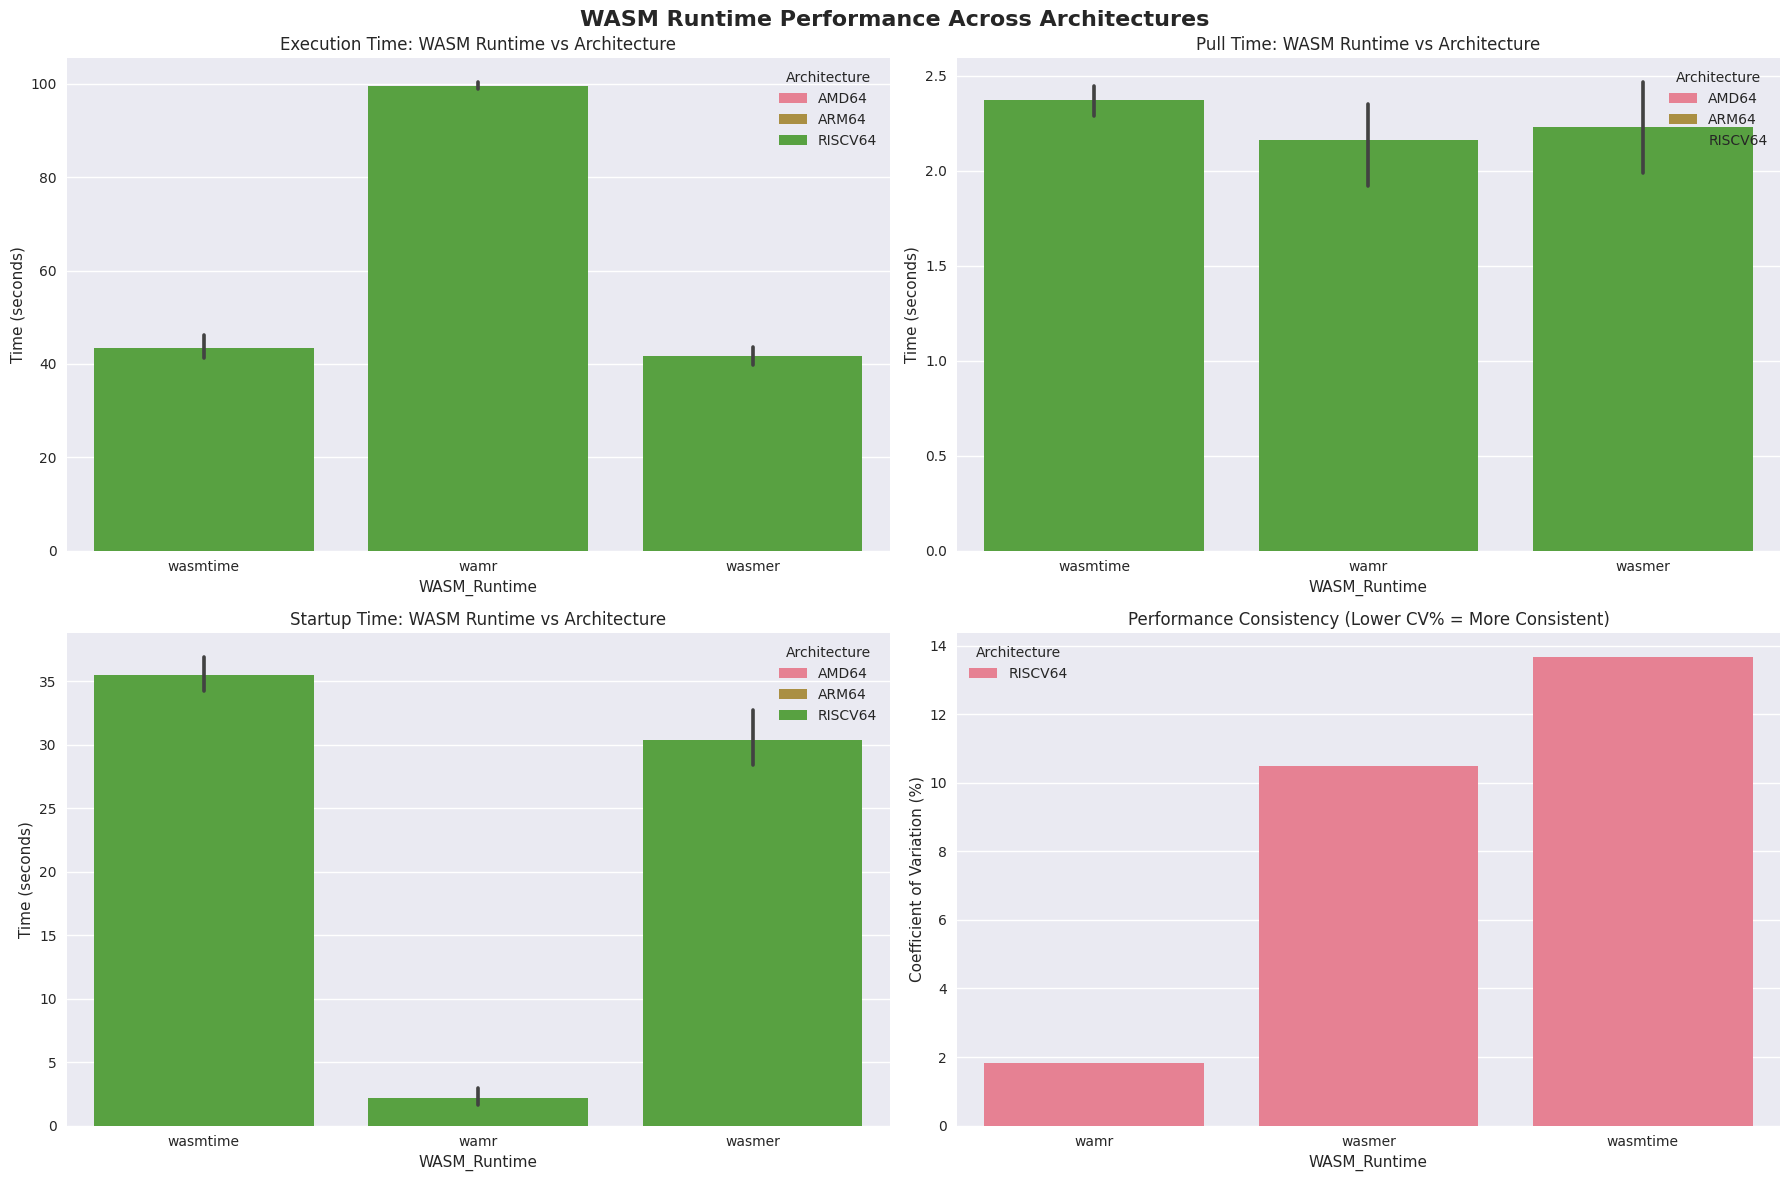


🚀 WASM Runtime Rankings by Architecture:

AMD64:

ARM64:

RISCV64:
  1. wasmer: 41.689s
  2. wasmtime: 43.504s
  3. wamr: 99.629s


In [7]:
if df is not None and has_architecture:
    wasm_df = df[df['Image Type'] == 'WebAssembly'].copy()
    
    if not wasm_df.empty and 'WASM_Runtime' in wasm_df.columns:
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('WASM Runtime Performance Across Architectures', fontsize=16, fontweight='bold')
        
        # 1. Execution time by WASM runtime and architecture
        ax1 = axes[0,0]
        sns.barplot(data=wasm_df, x='WASM_Runtime', y='Total Execution Time (s)', 
                   hue='Architecture', ax=ax1)
        ax1.set_title('Execution Time: WASM Runtime vs Architecture')
        ax1.set_ylabel('Time (seconds)')
        
        # 2. Pull time comparison
        ax2 = axes[0,1] 
        sns.barplot(data=wasm_df, x='WASM_Runtime', y='Pull Time (s)', 
                   hue='Architecture', ax=ax2)
        ax2.set_title('Pull Time: WASM Runtime vs Architecture')
        ax2.set_ylabel('Time (seconds)')
        
        # 3. Startup time (if available)
        ax3 = axes[1,0]
        startup_data = wasm_df[wasm_df['Container Start to Main Time (s)'].notna()]
        if not startup_data.empty:
            sns.barplot(data=startup_data, x='WASM_Runtime', y='Container Start to Main Time (s)', 
                       hue='Architecture', ax=ax3)
            ax3.set_title('Startup Time: WASM Runtime vs Architecture')
            ax3.set_ylabel('Time (seconds)')
        else:
            ax3.text(0.5, 0.5, 'No startup timing data', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Startup Time - No Data')
        
        # 4. Performance consistency (coefficient of variation)
        ax4 = axes[1,1]
        consistency = wasm_df.groupby(['Architecture', 'WASM_Runtime'])['Total Execution Time (s)'].agg(
            lambda x: (x.std() / x.mean()) * 100 if x.mean() > 0 else 0
        ).reset_index()
        consistency.columns = ['Architecture', 'WASM_Runtime', 'CV_Percent']
        
        sns.barplot(data=consistency, x='WASM_Runtime', y='CV_Percent', hue='Architecture', ax=ax4)
        ax4.set_title('Performance Consistency (Lower CV% = More Consistent)')
        ax4.set_ylabel('Coefficient of Variation (%)')
        
        plt.tight_layout()
        plt.show()
        
        # Print WASM runtime rankings
        print("\n🚀 WASM Runtime Rankings by Architecture:")
        print("=" * 50)
        
        for arch in wasm_df['Architecture'].unique():
            arch_data = wasm_df[wasm_df['Architecture'] == arch]
            rankings = arch_data.groupby('WASM_Runtime')['Total Execution Time (s)'].mean().sort_values()
            print(f"\n{arch}:")
            for rank, (runtime, time_val) in enumerate(rankings.items(), 1):
                print(f"  {rank}. {runtime}: {time_val:.3f}s")
    else:
        print("❌ No WASM runtime data available for analysis")
elif df is not None:
    print("⚠️ WASM runtime analysis not available for single-architecture dataset")

## Architecture-Specific Insights

In [8]:
if df is not None and has_architecture:
    print("\n🔬 ARCHITECTURE-SPECIFIC INSIGHTS")
    print("=" * 50)
    
    for arch in sorted(df['Architecture'].unique()):
        arch_data = df[df['Architecture'] == arch]
        
        print(f"\n🏗️ {arch} Analysis:")
        print("-" * 20)
        
        # Performance characteristics
        native_time = arch_data[arch_data['Image Type'] == 'Native']['Total Execution Time (s)'].mean()
        wasm_time = arch_data[arch_data['Image Type'] == 'WebAssembly']['Total Execution Time (s)'].mean()
        
        if pd.notna(native_time) and pd.notna(wasm_time) and native_time > 0:
            overhead = ((wasm_time / native_time) - 1) * 100
            print(f"• WASM overhead: {overhead:.1f}% vs native")
            
            if overhead > 200:
                print(f"  ⚠️ High WASM overhead - consider runtime optimization")
            elif overhead < 50:
                print(f"  ✅ Low WASM overhead - good performance")
        
        # Best runtime combination
        best_combo = arch_data.loc[arch_data['Total Execution Time (s)'].idxmin()]
        print(f"• Best combination: {best_combo['Runtime']} + {best_combo['Image Type']}")
        print(f"  Time: {best_combo['Total Execution Time (s)']:.3f}s")
        
        # Consistency analysis
        exec_times = arch_data['Total Execution Time (s)']
        cv = (exec_times.std() / exec_times.mean()) * 100 if exec_times.mean() > 0 else 0
        
        if cv < 10:
            print(f"• Performance consistency: Excellent ({cv:.1f}% CV)")
        elif cv < 25:
            print(f"• Performance consistency: Good ({cv:.1f}% CV)")
        else:
            print(f"• Performance consistency: Variable ({cv:.1f}% CV)")
        
        # Image size efficiency
        native_size = arch_data[arch_data['Image Type'] == 'Native']['Host Size (MB)'].mean()
        wasm_size = arch_data[arch_data['Image Type'] == 'WebAssembly']['Host Size (MB)'].mean()
        
        if pd.notna(native_size) and pd.notna(wasm_size) and native_size > 0:
            size_ratio = wasm_size / native_size
            if size_ratio < 1:
                print(f"• Image size: WASM {(1-size_ratio)*100:.1f}% smaller")
            else:
                print(f"• Image size: WASM {(size_ratio-1)*100:.1f}% larger")
    
    # Cross-architecture recommendations
    print("\n💡 CROSS-ARCHITECTURE RECOMMENDATIONS:")
    print("=" * 50)
    
    # Find universally best runtime
    runtime_scores = df.groupby('Runtime')['Total Execution Time (s)'].mean().sort_values()
    print(f"• Best overall runtime: {runtime_scores.index[0]} (avg: {runtime_scores.iloc[0]:.3f}s)")
    
    # Architecture-specific recommendations
    arch_best = df.groupby('Architecture')['Total Execution Time (s)'].mean().sort_values()
    print(f"• Fastest architecture: {arch_best.index[0]} (avg: {arch_best.iloc[0]:.3f}s)")
    print(f"• Consider {arch_best.index[0]} for performance-critical workloads")
    
    if len(arch_best) > 1:
        slowest_ratio = arch_best.iloc[-1] / arch_best.iloc[0]
        print(f"• Performance gap: {slowest_ratio:.1f}x between fastest and slowest")
        
elif df is not None:
    print("⚠️ Architecture-specific insights not available for single-architecture dataset")


🔬 ARCHITECTURE-SPECIFIC INSIGHTS

🏗️ AMD64 Analysis:
--------------------
• WASM overhead: 183.9% vs native
• Best combination: containerd + Native
  Time: 0.353s
• Performance consistency: Variable (50.2% CV)
• Image size: WASM 51.9% smaller

🏗️ ARM64 Analysis:
--------------------
• WASM overhead: 95.2% vs native
• Best combination: containerd + Native
  Time: 0.547s
• Performance consistency: Variable (39.1% CV)
• Image size: WASM 45.7% smaller

🏗️ RISCV64 Analysis:
--------------------
• WASM overhead: 1755.1% vs native
  ⚠️ High WASM overhead - consider runtime optimization
• Best combination: containerd + Native
  Time: 2.299s
• Performance consistency: Variable (73.9% CV)
• Image size: WASM 37.6% smaller

💡 CROSS-ARCHITECTURE RECOMMENDATIONS:
• Best overall runtime: containerd (avg: 23.440s)
• Fastest architecture: AMD64 (avg: 0.943s)
• Consider AMD64 for performance-critical workloads
• Performance gap: 49.9x between fastest and slowest


## Export Multi-Architecture Results

In [9]:
if df is not None:
    # Export comprehensive analysis
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if has_architecture:
        # Multi-architecture summary
        arch_summary = df.groupby(['Architecture', 'Runtime', 'Image Type']).agg({
            'Pull Time (s)': ['mean', 'std'],
            'Total Execution Time (s)': ['mean', 'std'], 
            'Container Start to Main Time (s)': 'mean',
            'Host Size (MB)': 'mean'
        }).round(3)
        
        arch_summary.to_csv(f'multiarch_summary_{timestamp}.csv')
        print(f"✅ Multi-architecture summary exported to: multiarch_summary_{timestamp}.csv")
        
        # WASM runtime comparison
        if 'WASM_Runtime' in df.columns:
            wasm_comparison = df[df['Image Type'] == 'WebAssembly'].groupby(
                ['Architecture', 'WASM_Runtime']
            )['Total Execution Time (s)'].agg(['mean', 'std', 'count']).round(3)
            
            wasm_comparison.to_csv(f'wasm_runtime_comparison_{timestamp}.csv')
            print(f"✅ WASM runtime comparison exported to: wasm_runtime_comparison_{timestamp}.csv")
    
    # Export enhanced dataset with analysis columns
    df.to_csv(f'enhanced_timing_analysis_{timestamp}.csv', index=False)
    print(f"✅ Enhanced dataset exported to: enhanced_timing_analysis_{timestamp}.csv")
    
    print(f"\n📁 Generated analysis files:")
    if has_architecture:
        print(f"   • multiarch_summary_{timestamp}.csv - Cross-architecture performance summary")
        if 'WASM_Runtime' in df.columns:
            print(f"   • wasm_runtime_comparison_{timestamp}.csv - WASM runtime performance")
    print(f"   • enhanced_timing_analysis_{timestamp}.csv - Complete dataset with analysis")
    print(f"   • analyze_multiarch_results.ipynb - This analysis notebook")
    
print("\n🎉 Multi-architecture analysis complete!")

if df is not None and has_architecture:
    print("\n📊 Key Takeaways:")
    print("• Compare performance characteristics across different CPU architectures")
    print("• Identify the best WASM runtime for each architecture")
    print("• Understand architecture-specific optimization opportunities")
    print("• Make informed decisions for multi-architecture deployments")

✅ Multi-architecture summary exported to: multiarch_summary_20250807_062328.csv
✅ WASM runtime comparison exported to: wasm_runtime_comparison_20250807_062328.csv
✅ Enhanced dataset exported to: enhanced_timing_analysis_20250807_062328.csv

📁 Generated analysis files:
   • multiarch_summary_20250807_062328.csv - Cross-architecture performance summary
   • wasm_runtime_comparison_20250807_062328.csv - WASM runtime performance
   • enhanced_timing_analysis_20250807_062328.csv - Complete dataset with analysis
   • analyze_multiarch_results.ipynb - This analysis notebook

🎉 Multi-architecture analysis complete!

📊 Key Takeaways:
• Compare performance characteristics across different CPU architectures
• Identify the best WASM runtime for each architecture
• Understand architecture-specific optimization opportunities
• Make informed decisions for multi-architecture deployments
